# Deep Learning for Medical Image Analysis
## MICCAI Grand Challenge - Foot ulcer segmentation challenge 


### import the libraries

In [56]:
import os

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

import numpy as np
import keras
import random

import matplotlib.pyplot as plt

In [57]:
# keras.__version__
os.environ["SM_FRAMEWORK"] = "tf.keras"
print(tf.__version__)

2.13.0


In [58]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

### clone the git repository

In [59]:
!git clone https://github.com/uwm-bigdata/wound-segmentation.git

fatal: destination path 'wound-segmentation' already exists and is not an empty directory.


### check if GPU is used

In [60]:
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


### Core parameters used

In [61]:
# Resizing the images
img_size = (160, 160) #(128, 128)

# Number of classes (binary: black or white, thus one class sufficient)
num_classes = 1

# Batch size of 32 
batch_size = 32

## Preprocessing

### sort data: training images and training ground truth  

In [62]:
# path to training data and ground truth
input_dir = "wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/"
target_dir = "wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/"

# sort input images by name
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)

# sort segmentation masks by name
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

# print number of total images
print("Number of samples:", len(input_img_paths))

# verify for the first 5 images that they are correctly aligned with their segmentation masks
for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)

Number of samples: 810
wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0011.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0011.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0012.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0012.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0013.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0013.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0014.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0014.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0015.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0015.png


### Displaying an example image of the dataset and its segmentation

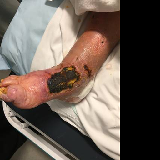

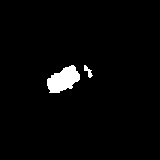

In [63]:
# display example
display(load_img(input_img_paths[10], target_size=img_size))

# display mask
display(load_img(target_img_paths[10], target_size=img_size))

### sort data: validation images and validation ground truth  

In [64]:
# path to validation data and ground truth
val_input_dir = "wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/"
val_target_dir = "wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/"

# sort input images by name
val_input_img_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".png")
    ]
)

# sort segmentation masks by name
val_target_img_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png")
    ]
)

# print number of total images
print("Number of samples:", len(val_input_img_paths))

# verify for the first 5 images that they are correctly aligned with their segmentation masks
for input_path, target_path in zip(val_input_img_paths[:5], val_target_img_paths[:5]):
    print(input_path, "|", target_path)

Number of samples: 200
wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0001.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0001.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0002.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0002.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0003.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0003.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0004.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0004.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0005.png | wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0005.png


### load all images from file into python datastructure and already resize them

In [65]:
# training images
all_images = [load_img(i_path, target_size=img_size) for i_path in input_img_paths]

all_masks = [load_img(t_path, target_size=img_size, color_mode="grayscale") for t_path in target_img_paths]

#validation images
val_all_images = [load_img(i_path, target_size=img_size) for i_path in val_input_img_paths]

val_all_masks = [load_img(t_path, target_size=img_size, color_mode="grayscale") for t_path in val_target_img_paths]

### convert to numpy array and normalize the data to [0,1]

In [66]:
# training
all_images_normalized = [np.array(image, dtype='float32')/255 for image in all_images]

all_masks_normalized = [np.array(image, dtype='float32')/255 for image in all_masks]

#validation
val_all_images_normalized = [np.array(image, dtype='float32')/255 for image in val_all_images]

val_all_masks_normalized = [np.array(image, dtype='float32')/255 for image in val_all_masks]

### convert to numpy arrays

In [67]:
# training
all_images_normalized = np.array(all_images_normalized)

all_masks_normalized = np.array(all_masks_normalized)

# validation
val_all_images_normalized = np.array(val_all_images_normalized)

val_all_masks_normalized = np.array(val_all_masks_normalized)

In [68]:
print(all_images_normalized.shape)
print(val_all_images_normalized.shape)

(810, 160, 160, 3)
(200, 160, 160, 3)


### add new axis for adding an output channel: black or white, i.e. (900, 160, 160) -> (900, 160, 160, 1)

In [69]:
# training
all_masks_normalized = all_masks_normalized[..., np.newaxis]

#validation
val_all_masks_normalized = val_all_masks_normalized[..., np.newaxis]

### check shapes

In [70]:
print(all_images_normalized.shape)
print(val_all_images_normalized.shape)

(810, 160, 160, 3)
(200, 160, 160, 3)


In [71]:
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

# print(model.summary())

## Model architecture

In [72]:
#filters = [8, 16, 24, 32]
filters = [8, 16, 32, 64]
#filters = [16, 32, 64, 128]
dropout_probability = 0.2

### define the U-Net model

In [73]:
def get_unet_model(img_size, num_classes, filters):
    inputs = keras.Input(shape=img_size + (3,))

    skips = []
    
    filters_backwards = filters[::-1]
    
    ### [ENCODER: First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(filters[0], 3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
        
    x = layers.Conv2D(filters[0], 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skips.append(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(dropout_probability)(x)

    for f in filters[1:]:
        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        x = layers.Dropout(dropout_probability)(x)

    ### [DECODER: Second half of the network: upsampling inputs] ###

    f = filters_backwards[0]
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(2)(x)

    x = layers.Dropout(dropout_probability)(x)

    for i, f in enumerate(filters_backwards[1:], start=1):
        x = layers.Concatenate()([x, skips[-i]]) # UNet skip connection with concatenation operation

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.UpSampling2D(2)(x)

        x = layers.Dropout(dropout_probability)(x)

    x = layers.Concatenate()([x, skips[0]]) # UNet skip connection with concatenation operation

    # Add a per-pixel classification layer with sigmoid as non linear activation function
    outputs = layers.Conv2DTranspose(num_classes, 3, activation="sigmoid", padding="same")(x) 

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

### define the LinkNet model

In [74]:
def get_linknet_model(img_size, num_classes, filters):
    inputs = keras.Input(shape=img_size + (3,))

    skips = []
    
    filters_backwards = filters[::-1]
    
    ### [ENCODER: First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(filters[0], 3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters[0], 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skips.append(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(.2)(x)

    for f in filters[1:]:
        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        x = layers.Dropout(.2)(x)

    ### [DECODER: Second half of the network: upsampling inputs] ###

    f = filters_backwards[0]
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(2)(x)

    x = layers.Dropout(.2)(x)

    for i, f in enumerate(filters_backwards[1:], start=1):
        x = layers.Add()([x, skips[-i]]) # LinkNet skip connection with adding operation

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.UpSampling2D(2)(x)

        x = layers.Dropout(.2)(x)

    x = layers.Add()([x, skips[0]]) # LinkNet skip connection with adding operation

    # Add a per-pixel classification layer with sigmoid as non linear activation function
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x) 

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

### define ensemble model (averaging unet / linknet probability masks)

In [75]:
def unet(inputs, filters):
    skips = []
    
    filters_backwards = filters[::-1]
    
    ### [ENCODER: First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(filters[0], 3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
        
    x = layers.Conv2D(filters[0], 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skips.append(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(dropout_probability)(x)

    for f in filters[1:]:
        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        x = layers.Dropout(dropout_probability)(x)

    ### [DECODER: Second half of the network: upsampling inputs] ###

    f = filters_backwards[0]
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(2)(x)

    x = layers.Dropout(dropout_probability)(x)

    for i, f in enumerate(filters_backwards[1:], start=1):
        x = layers.Concatenate()([x, skips[-i]]) # UNet skip connection with concatenation operation

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.UpSampling2D(2)(x)

        x = layers.Dropout(dropout_probability)(x)

    x = layers.Concatenate()([x, skips[0]]) # UNet skip connection with concatenation operation
    
    return x

def linknet(inputs, filters):
    skips = []
    
    filters_backwards = filters[::-1]
    
    ### [ENCODER: First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(filters[0], 3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters[0], 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skips.append(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(.2)(x)

    for f in filters[1:]:
        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        x = layers.Dropout(.2)(x)

    ### [DECODER: Second half of the network: upsampling inputs] ###

    f = filters_backwards[0]
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2DTranspose(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(2)(x)

    x = layers.Dropout(.2)(x)

    for i, f in enumerate(filters_backwards[1:], start=1):
        x = layers.Add()([x, skips[-i]]) # LinkNet skip connection with adding operation

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(f, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.UpSampling2D(2)(x)

        x = layers.Dropout(.2)(x)

    x = layers.Add()([x, skips[0]]) # LinkNet skip connection with adding operation

    return x

def get_ensemble_model(img_size, num_classes, filters):
    inputs = keras.Input(shape=img_size + (3,))
    
    results = []

    x = unet(inputs, filters)
    
    results.append(x)
    
    adapted_filters = filters[1:] + [filters[-1]*2]
    x = linknet(inputs, adapted_filters)
    
    results.append(x)
    
    # take average of unet and linknet
    sum_results = results[0]
    for r in results[1:]:
        sum_results = layers.Add()([sum_results, r])
    sum_results = sum_results / len(results)
    x = sum_results

    # Add a per-pixel classification layer with sigmoid as non linear activation function
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x) 

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [79]:
keras.backend.clear_session()

selected_model = "ensemble" 

if selected_model == "unet":
    model = get_unet_model(img_size, num_classes, filters)
elif selected_model == "linknet":
    model = get_linknet_model(img_size, num_classes, filters)
elif selected_model == "ensemble":
    model = get_ensemble_model(img_size, num_classes, filters)
else:
    print("please specify the model")

In [37]:

    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 160, 160, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 160, 160, 16)         448       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 160, 160, 8)          0         ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 batch_normalization_2 (Bat  (None, 40, 40, 32)           128       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 40, 40, 64)           256       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_5 (Activation)   (None, 40, 40, 32)           0         ['batch_normalization_2[0][0]'
                                                                    ]                             
                                                                                                  
 activatio

                                                                    ']                            
                                                                                                  
 up_sampling2d (UpSampling2  (None, 20, 20, 64)           0         ['activation_9[0][0]']        
 D)                                                                                               
                                                                                                  
 up_sampling2d_4 (UpSamplin  (None, 20, 20, 128)          0         ['activation_25[0][0]']       
 g2D)                                                                                             
                                                                                                  
 dropout_4 (Dropout)         (None, 20, 20, 64)           0         ['up_sampling2d[0][0]']       
                                                                                                  
 dropout_1

                                                                                                  
 activation_13 (Activation)  (None, 40, 40, 16)           0         ['batch_normalization_6[0][0]'
                                                                    ]                             
                                                                                                  
 activation_29 (Activation)  (None, 40, 40, 32)           0         ['batch_normalization_14[0][0]
                                                                    ']                            
                                                                                                  
 up_sampling2d_2 (UpSamplin  (None, 80, 80, 16)           0         ['activation_13[0][0]']       
 g2D)                                                                                             
                                                                                                  
 up_sampli

### Variants of Segmentation Models

In [77]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

85521592/85521592 [==============================] - 43s 1us/step


In [78]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit3_relu1[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit3_conv1 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_6[0][0]']    
 )                                                                                                
                                                                                                  
 stage1_unit3_bn2 (BatchNor  (None, None, None, 64)       256       ['stage1_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage1_un

                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit3_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit3_conv1 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_12[0][0]']   
 )                                                                                                
                                                                                                  
 stage2_unit3_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_un

                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit2_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit2_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_18[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit2_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_un

 ding2D)                                                                                          
                                                                                                  
 stage3_unit5_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_24[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit5_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit5_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit5_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit5_bn2[0][0]']    
 tion)                                                                                            
          

 ding2D)                                                                                          
                                                                                                  
 stage4_unit2_conv1 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_30[0][0]']   
 )                                                                                                
                                                                                                  
 stage4_unit2_bn2 (BatchNor  (None, None, None, 512)      2048      ['stage4_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit2_relu2 (Activa  (None, None, None, 512)      0         ['stage4_unit2_bn2[0][0]']    
 tion)                                                                                            
          

 decoder_stage1a_conv (Conv  (None, None, None, 128)      442368    ['decoder_stage1_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage1a_bn (BatchN  (None, None, None, 128)      512       ['decoder_stage1a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage1a_relu (Acti  (None, None, None, 128)      0         ['decoder_stage1a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1b_conv (Conv  (None, None, None, 128)      147456    ['decoder_stage1a_relu[0][0]']
 2D)      

 decoder_stage4b_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage4b_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 final_conv (Conv2D)         (None, None, None, 1)        145       ['decoder_stage4b_relu[0][0]']
                                                                                                  
 sigmoid (Activation)        (None, None, None, 1)        0         ['final_conv[0][0]']          
                                                                                                  
Total para

In [91]:
BACKBONE = 'efficientnetb2'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model2 = sm.Linknet(BACKBONE, encoder_weights='imagenet')
model2.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
print(model2.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['input_9[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 32)       128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 32)       0         ['stem_bn[0][0]']      

                                                                                                  
 block2a_dwconv (DepthwiseC  (None, None, None, 96)       864       ['block2a_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block2a_bn (BatchNormaliza  (None, None, None, 96)       384       ['block2a_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block2a_activation (Activa  (None, None, None, 96)       0         ['block2a_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block2a_s

                                                                                                  
 block2c_bn (BatchNormaliza  (None, None, None, 144)      576       ['block2c_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block2c_activation (Activa  (None, None, None, 144)      0         ['block2c_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block2c_se_squeeze (Global  (None, 144)                  0         ['block2c_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block2c_s

                                                                                                  
 block3b_activation (Activa  (None, None, None, 288)      0         ['block3b_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block3b_se_squeeze (Global  (None, 288)                  0         ['block3b_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block3b_se_reshape (Reshap  (None, 1, 1, 288)            0         ['block3b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block3b_s

                                                                                                  
 block4a_bn (BatchNormaliza  (None, None, None, 288)      1152      ['block4a_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block4a_activation (Activa  (None, None, None, 288)      0         ['block4a_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block4a_se_squeeze (Global  (None, 288)                  0         ['block4a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4a_s

                                                                                                  
 block4c_activation (Activa  (None, None, None, 528)      0         ['block4c_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block4c_se_squeeze (Global  (None, 528)                  0         ['block4c_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4c_se_reshape (Reshap  (None, 1, 1, 528)            0         ['block4c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4c_s

                                                                                                  
 block5a_bn (BatchNormaliza  (None, None, None, 528)      2112      ['block5a_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block5a_activation (Activa  (None, None, None, 528)      0         ['block5a_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block5a_se_squeeze (Global  (None, 528)                  0         ['block5a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5a_s

                                                                                                  
 block5c_activation (Activa  (None, None, None, 720)      0         ['block5c_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block5c_se_squeeze (Global  (None, 720)                  0         ['block5c_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5c_se_reshape (Reshap  (None, 1, 1, 720)            0         ['block5c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5c_s

                                                                                                  
 block6a_bn (BatchNormaliza  (None, None, None, 720)      2880      ['block6a_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block6a_activation (Activa  (None, None, None, 720)      0         ['block6a_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6a_se_squeeze (Global  (None, 720)                  0         ['block6a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6a_s

                                                                                                  
 block6c_activation (Activa  (None, None, None, 1248)     0         ['block6c_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6c_se_squeeze (Global  (None, 1248)                 0         ['block6c_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6c_se_reshape (Reshap  (None, 1, 1, 1248)           0         ['block6c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6c_s

                                                                                                  
 block6e_bn (BatchNormaliza  (None, None, None, 1248)     4992      ['block6e_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block6e_activation (Activa  (None, None, None, 1248)     0         ['block6e_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6e_se_squeeze (Global  (None, 1248)                 0         ['block6e_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6e_s

                                                                                                  
 block7b_activation (Activa  (None, None, None, 2112)     0         ['block7b_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block7b_se_squeeze (Global  (None, 2112)                 0         ['block7b_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block7b_se_reshape (Reshap  (None, 1, 1, 2112)           0         ['block7b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block7b_s

 decoder_stage1b_conv (Conv  (None, None, None, 180)      291600    ['decoder_stage1_upsampling[0]
 2D)                                                                [0]']                         
                                                                                                  
 decoder_stage1b_bn (BatchN  (None, None, None, 180)      720       ['decoder_stage1b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage1b_relu (Acti  (None, None, None, 180)      0         ['decoder_stage1b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1c_conv (Conv  (None, None, None, 288)      51840     ['decoder_stage1b_relu[0][0]']
 2D)      

 decoder_stage3c_relu (Acti  (None, None, None, 96)       0         ['decoder_stage3c_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage3_add (Add)    (None, None, None, 96)       0         ['decoder_stage3c_relu[0][0]',
                                                                     'block2a_expand_activation[0]
                                                                    [0]']                         
                                                                                                  
 decoder_stage4a_conv (Conv  (None, None, None, 24)       2304      ['decoder_stage3_add[0][0]']  
 2D)                                                                                              
                                                                                                  
 decoder_s

### free up RAM in case the model definition cells were run multiple times and build model

## Training and validation data
### split our img paths into a training and a validation set:

In [93]:
import time

# shuffle input images and corresponding masks to introduce randomness, but same random seed that shuffle keeps them aligned
random.Random(63).shuffle(all_images_normalized) #int(time.time())
random.Random(63).shuffle(all_masks_normalized)

random.Random(100).shuffle(val_all_images_normalized)
random.Random(100).shuffle(val_all_masks_normalized)

# assign training set
dice=80.23
train_imgs = all_images_normalized
train_msks = all_masks_normalized

# assign validation set (take second half of validation set)
val_imgs = val_all_images_normalized[:len(val_all_images_normalized)//2]
val_msks = val_all_masks_normalized[:len(val_all_images_normalized)//2]

# assign test set (take second half of validation set)
test_imgs = val_all_images_normalized[len(val_all_images_normalized)//2:]
test_msks = val_all_masks_normalized[len(val_all_images_normalized)//2:]

train_gen = (train_imgs, train_msks)
val_gen = (val_imgs, val_msks)

test_gen = (test_imgs, test_msks)

### check lengths and shapes

In [94]:
print("Lengths Train, Val, Test: ", len(train_imgs), len(val_imgs), len(test_imgs))


print("Train Shapes: ", train_imgs.shape, train_msks.shape)
print("Val Shapes: ", val_imgs.shape, val_msks.shape)
print("Test Shapes: ", test_imgs.shape, test_msks.shape)

Lengths Train, Val, Test:  810 100 100
Train Shapes:  (810, 160, 160, 3) (810, 160, 160, 1)
Val Shapes:  (100, 160, 160, 3) (100, 160, 160, 1)
Test Shapes:  (100, 160, 160, 3) (100, 160, 160, 1)


## Data augmentation: 
### execute the next 4 cells only if data augmentation should be applied

In [95]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs, val_msks))

### check if shapes are correct: for input: (img_size1, img_size2, 3), for mask: (img_size1, img_size2, 1)

In [96]:
for x,y in train_dataset:
    print(x.shape, y.shape)
    break

(160, 160, 3) (160, 160, 1)


### Augmentations: Flippings and Rotations

In [42]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    # augmentations that dont move the image can be added here
    self.augment_inputs = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical", seed=seed),
      layers.RandomRotation(0.25, seed=seed+1),
    ])
    
    self.augment_labels = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical", seed=seed),
      layers.RandomRotation(0.25, seed=seed+1),
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

### map augmentations to training set

In [43]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(1000)
    .batch(batch_size)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_dataset.batch(batch_size)

### Configure the model for training.
### use the binary cross entropy as the model segments into 0 (black) or 1 (white)

In [44]:
import keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# different options for loss:
dice = 80.22
# 1. loss="binary_crossentropy"
# 2. loss="binary_focal_crossentropy"
# 3. loss=dice_loss

model.compile(optimizer="adam", loss="binary_crossentropy", # optimizer=opt for SGD optimizer
              metrics=['accuracy',
                       keras.metrics.Recall(), # is same as sensitivity
                       keras.metrics.FalseNegatives(), 
                       keras.metrics.FalsePositives(), 
                       keras.metrics.TrueNegatives(),
                       keras.metrics.TruePositives(),
                       keras.metrics.AUC()]) # area under roc curve

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoint_best_validation.h5", save_best_only=True)
]

## Training phase (with data augmentation)
### Train the model, doing validation at the end of each epoch.

In [65]:
epochs = 50
model_history = model.fit(train_batches, epochs=epochs, validation_data=val_batches, callbacks=callbacks)

Epoch 1/50
26/26 [==============================] - 24s 882ms/step - loss: 0.4551 - accuracy: 0.8084 - recall: 0.2047 - false_negatives: 245304.0000 - false_positives: 3708930.0000 - true_negatives: 16718615.0000 - true_positives: 63151.0000 - auc: 0.5940 - val_loss: 0.3847 - val_accuracy: 0.9887 - val_recall: 0.0000e+00 - val_false_negatives: 28811.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 2531189.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.1968
Epoch 2/50


/Users/alok/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 23s 876ms/step - loss: 0.1075 - accuracy: 0.9843 - recall: 0.0011 - false_negatives: 309078.0000 - false_positives: 15557.0000 - true_negatives: 20411012.0000 - true_positives: 351.0000 - auc: 0.8390 - val_loss: 0.2231 - val_accuracy: 0.9887 - val_recall: 0.0000e+00 - val_false_negatives: 28811.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 2531189.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.5798
Epoch 3/50
26/26 [==============================] - 23s 889ms/step - loss: 0.0662 - accuracy: 0.9856 - recall: 0.0460 - false_negatives: 294845.0000 - false_positives: 3807.0000 - true_negatives: 20423148.0000 - true_positives: 14203.0000 - auc: 0.9282 - val_loss: 0.1326 - val_accuracy: 0.9887 - val_recall: 0.0000e+00 - val_false_negatives: 28811.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 2531189.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.8210
Epoch 4/50
26/26 [==============================] - 23s 897ms/st

KeyboardInterrupt: 

In [98]:
model2.fit(
    x=train_imgs,
    y=train_msks,
    batch_size=16,
    epochs=100,
    validation_data=(val_imgs, val_msks),
)

Epoch 1/100
51/51 [==============================] - 51s 933ms/step - loss: 1.2687 - iou_score: 0.0559 - val_loss: 2.0772 - val_iou_score: 0.0169
Epoch 2/100
 6/51 [==>...........................] - ETA: 41s - loss: 0.9130 - iou_score: 0.1593

KeyboardInterrupt: 

## Training and Validation Performance
### get the history of the model to access the metrics

In [42]:
history_dict = model_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'recall', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives', 'val_auc'])

In [43]:
ep = range(1, epochs + 1)

### get training and validation loss

In [44]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

### plot training and validation loss

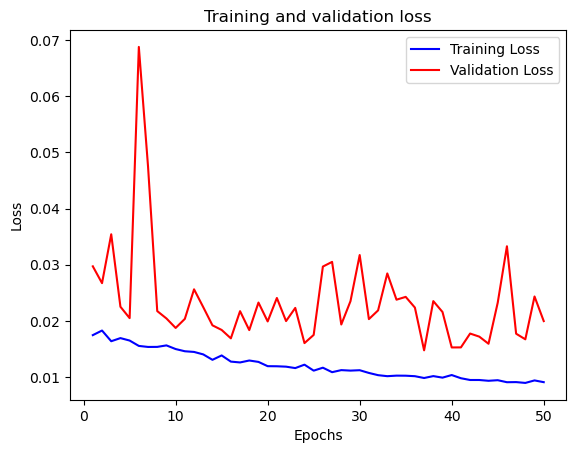

In [45]:
# plot training loss
plt.plot(ep, loss, 'b', label='Training Loss')
# plot validation loss
plt.plot(ep, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### get accuracy scores

In [46]:
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

### plot training and validation accuracy

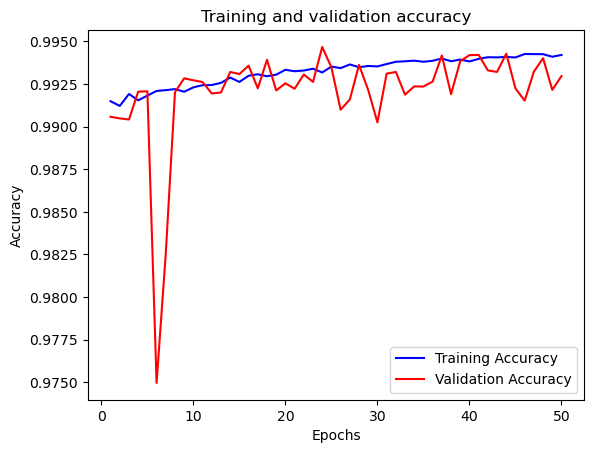

In [47]:
# plot training accuracy
plt.plot(ep, accuracy, 'b', label='Training Accuracy')
# plot validation accuracy
plt.plot(ep, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## compute and print all relevant metrics 

In [62]:
# get "best" epoch
from operator import itemgetter
best_epoch, _ = max(enumerate(val_accuracy), key=itemgetter(1))

# compute all metrics (dict key names might need to be adapted)
val_TN = history_dict['val_true_negatives']

val_FP = history_dict['val_false_positives']

val_TP = history_dict['val_true_positives']

val_FN = history_dict['val_false_negatives']

val_sensitivity = history_dict['val_recall']

val_specificity = [x/(x+y) for x,y in zip(val_TN, val_FP)]

val_accuracy = history_dict['val_accuracy']

val_jaccard = [x/(x+y+z) for x,y,z in zip(val_TP, val_FP, val_FN)]

val_auc = history_dict['val_auc']

# print all relevant metrics for the best epoch of one model

print("Sensitivity: ", val_sensitivity[best_epoch])
print("Specificity: ", val_specificity[best_epoch])
print("Accuracy: ", val_accuracy[best_epoch])
print("Jaccard index: ", val_jaccard[best_epoch])
print("Dice coefficient: ", dice)
print("AUC: ", val_auc[best_epoch])

print(val_sensitivity[best_epoch], "&", val_specificity[best_epoch], "&", val_accuracy[best_epoch], "&", val_jaccard[best_epoch], "&", val_dice[best_epoch], "&", val_auc[best_epoch])

Sensitivity:  0.6727291941642761
Specificity:  0.9983407007536774
Accuracy:  0.9946761727333069
Jaccard index:  0.587137620793069
Dice coefficient:  80.23
AUC:  0.978805422782898
0.6727291941642761 & 0.9983407007536774 & 0.9946761727333069 & 0.587137620793069 & 0.739869829939114 & 0.978805422782898


### get values for ROC curve

In [63]:
from sklearn.metrics import roc_curve, auc

val_preds = model.predict(val_imgs)

fpr, tpr, _ = roc_curve(val_msks.ravel(), val_preds.ravel())
roc_auc = auc(fpr,tpr)

4/4 [==============================] - 1s 165ms/step


### plot ROC curve

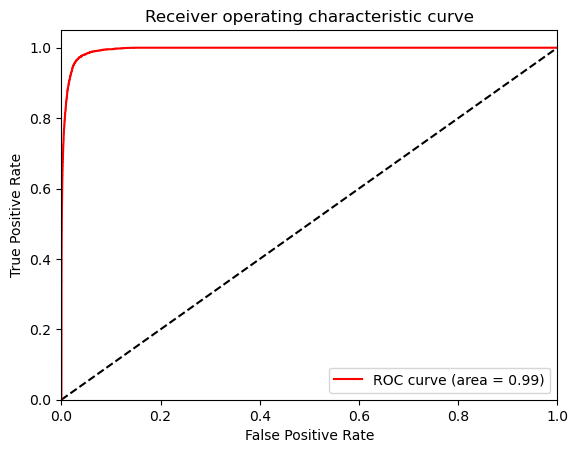

In [64]:
# draw y = x 
plt.plot([0,1], [0,1], 'k--')
# draw roc curve
plt.plot(fpr, tpr, 'r', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

## Evaluation 

### (if wanted) Save the weights of current model

In [66]:
model.save_weights('./checkpoints/current_model.h5')

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = './checkpoints/current_model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

### Loads the weights of the model in epoch with best validation performance

In [1]:
checkpoint_path = "unet_1.h5"
model.load_weights(checkpoint_path)

NameError: name 'model' is not defined

### evaluating the model based on its performance on the test set

In [53]:
# Evaluate the model on the test data using `evaluate`
model_performance = model.evaluate(test_imgs, test_msks, batch_size=batch_size)
print("test metrics:", model_performance)

4/4 [==============================] - 1s 171ms/step - loss: 0.0172 - accuracy: 0.9938 - recall_1: 0.5000 - false_negatives_1: 14377.0000 - false_positives_1: 1524.0000 - true_negatives_1: 2529723.0000 - true_positives_1: 14376.0000 - auc_1: 0.9806
test metrics: [0.017169907689094543, 0.9937886595726013, 0.499982625246048, 14377.0, 1524.0, 2529723.0, 14376.0, 0.9806294441223145]


## compute and print all relevant metrics 

In [67]:
# compute all metrics
TN = model_performance[5]

FP = model_performance[4]

TP = model_performance[6]

FN = model_performance[3]

sensitivity = model_performance[2]

specificity = TN/(TN+FP)

accuracy = model_performance[1]

jaccard = TP/(TP + FP + FN)

auc = model_performance[7]

# print all relevant metrics for the best epoch of one model

print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Accuracy: ", accuracy)
print("Jaccard index: ", jaccard)
print("Dice coefficient: ", dice)
print("AUC: ", auc)

# for Latex 
print(sensitivity, "&", specificity, "&", accuracy, "&", jaccard, "&", dice, "&", auc)

Sensitivity:  0.499982625246048
Specificity:  0.9993979252123558
Accuracy:  0.9937886595726013
Jaccard index:  0.47481586682960664
Dice coefficient:  80.23
AUC:  0.9806294441223145
0.499982625246048 & 0.9993979252123558 & 0.9937886595726013 & 0.47481586682960664 & 80.23 & 0.9806294441223145


### get values for ROC curve

In [36]:
from sklearn.metrics import roc_curve, auc

test_preds = model.predict(test_imgs)

fpr, tpr, _ = roc_curve(test_msks.ravel(), test_preds.ravel())
roc_auc = auc(fpr,tpr)

4/4 [==============================] - 1s 176ms/step


### plot ROC curve

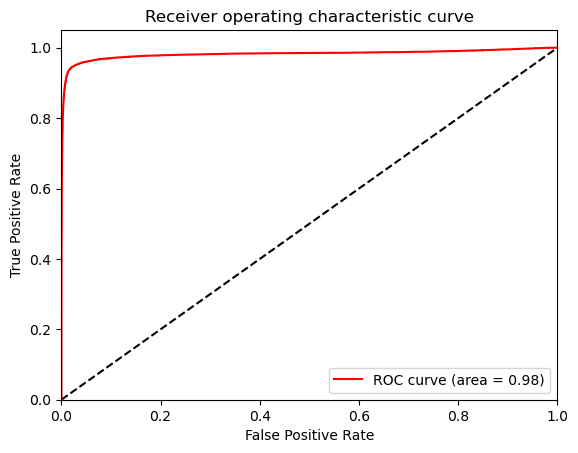

In [37]:
# draw y = x 
plt.plot([0,1], [0,1], 'k--')
# draw roc curve
plt.plot(fpr, tpr, 'r', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

## Make predictions

### Load unlabeled test data (only used for random predictions)

In [25]:
# path to validation data and ground truth
unlabeled_test_input_dir = "wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/"

# sort input images by name
unlabeled_test_input_img_paths = sorted(
    [
        os.path.join(unlabeled_test_input_dir, fname)
        for fname in os.listdir(unlabeled_test_input_dir)
        if fname.endswith(".png")
    ]
)

# print number of total images
print("Number of samples:", len(unlabeled_test_input_img_paths))

# verify for the first 5 images that they are correctly aligned with their segmentation masks
for input_path in unlabeled_test_input_img_paths[:5]:
    print(input_path)

Number of samples: 200
wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/1011.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/1014.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/1016.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/1018.png
wound-segmentation/data/Foot Ulcer Segmentation Challenge/test/images/1020.png


### Preprocessing

In [26]:
unlabeled_test_all_images = [load_img(i_path, target_size=img_size) for i_path in unlabeled_test_input_img_paths]

unlabeled_test_all_images_normalized = [np.array(image, dtype='float32')/255 for image in unlabeled_test_all_images]

unlabeled_test_all_images_normalized = np.array(unlabeled_test_all_images_normalized)

#test_all_images_normalized = test_all_images_normalized[..., np.newaxis]

print(unlabeled_test_all_images_normalized.shape)

unlabeled_test_imgs = unlabeled_test_all_images_normalized

(200, 160, 160, 3)


### Generate prediction for one image
As can be seen, the prediction mask is already very good

1/1 [==============================] - 0s 37ms/step


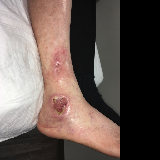

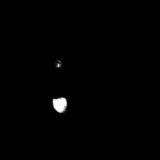

In [31]:
# specify image here
pred = model.predict(unlabeled_test_imgs[0:1])

# Display input image
display(keras.preprocessing.image.array_to_img(unlabeled_test_imgs[0]))

# Display prediction mask
display(ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred[0])))